# CVA System Identification: Newell-Lee Evaporator

In [2]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import time
import pandas as pd
import numpy as np
import pickle

## Load the Data Set

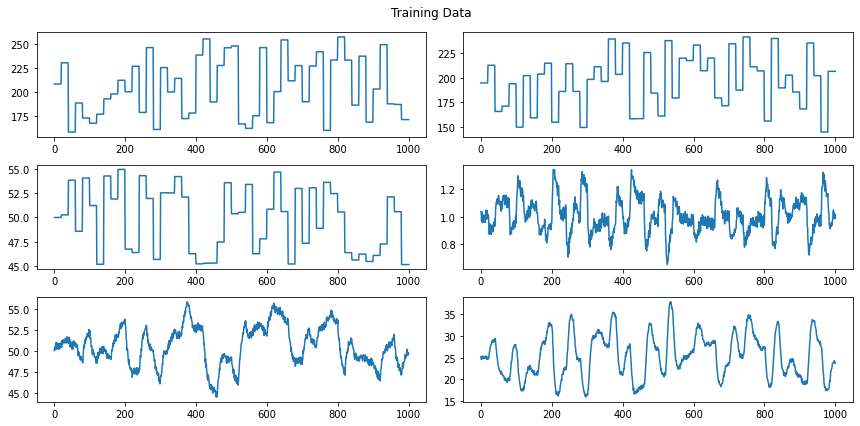

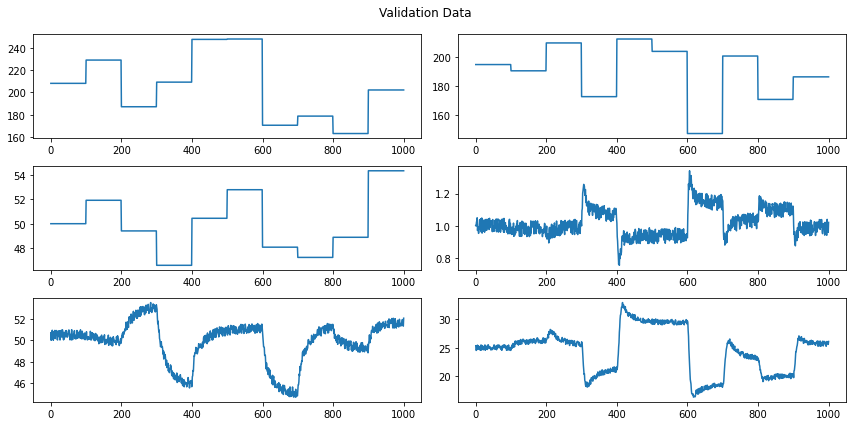

(1001, 6)
(1001, 6)


In [3]:
evap_df = pd.read_csv('evap_seed1.csv', index_col=0)
evap_df2 = pd.read_csv('evap_seed3_valid.csv', index_col=0)

v_name = ['F200', 'P100', 'F3', 'L2', 'P2', 'X2']
noise_var = np.array([0, 0, 0, 0.1, 1, 1])

np.random.seed(0)

def prepare_and_plot(evap_df, noise_var, label):
    plt.figure(figsize=(12, 6))
    timepts = np.linspace(0, 1000, 1001)
    ctr = 1
    res = list()
    for j in range(len(v_name)):
        plt.subplot(3,2,ctr)
        data = np.interp(timepts, evap_df.index.values, evap_df[v_name[j]].values)
        data += (np.random.rand(len(data))-0.5)*noise_var[j]
        res.append(data)
        plt.plot(data)
        ctr += 1

    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    
    return np.transpose(np.vstack(res))

Z_train = prepare_and_plot(evap_df, noise_var, 'Training Data')
Z_valid = prepare_and_plot(evap_df2, noise_var, 'Validation Data')
print(Z_train.shape)
print(Z_valid.shape)

## Declare CVA class

In [11]:
class CVA:
    def __init__(self, verbose=None):
        if verbose == None:
            self.verbose = 0
        else:
            self.verbose = verbose
    
    def identify(self, Z_train, UI, YI, n_states=None):
        
        start = time()
        self.UI = UI  # Column indices of input vars 
        self.YI = YI  # Column indices of output vars
        N = Z_train.shape[0]

        # Perform Standard Scaling on raw data [u y]
        sc_raw = StandardScaler()
        Z_train_sc = sc_raw.fit_transform(Z_train)
        y_train = Z_train_sc[:, YI]
        self.sc_raw = sc_raw

        # Calculate the suggested no. of lags
        _, ci = sm.tsa.acf(np.sum(y_train ** 2, axis=1), alpha=0.05)
        self.n_lags = np.argwhere(ci[:,0] < 0)[0][0]
        p = f = self.n_lags
        
        # Create Hankel matrices: Yp and Yf
        Yp, Yf = [], []
        for k in np.arange(N-p-f):
            Yp.append(np.flip(Z_train_sc[k:k+p, :].reshape(-1, 1)))

        for k in np.arange(1, N-p-f+1):
            Yf.append(Z_train_sc[k+p:k+p+f, YI].reshape(-1, 1))

        Yp = np.transpose(np.hstack(Yp))
        Yf = np.transpose(np.hstack(Yf))
        Np = Yp.shape[0]

        # Standardize the Hankel matrices
        sc_p = StandardScaler()
        sc_f = StandardScaler()
        Yp_scaled = sc_p.fit_transform(Yp)
        Yf_scaled = sc_f.fit_transform(Yf)
        self.sc_p = sc_p

        # Perform CCA
        Epp = cholesky(np.dot(Yp_scaled.T, Yp_scaled))  # Past Cholesky matrix
        Eff = cholesky(np.dot(Yf_scaled.T, Yf_scaled))  # Future Cholesky matrix
        Efp = np.dot(Yf_scaled.T, Yp_scaled)            # Cross-covariance matrix
        H = np.linalg.inv(Eff.T) @ Efp @ np.linalg.inv(Epp)

        U, S, V = np.linalg.svd(H)

        # Calculate the suggested no. of states via knee of SV plot
        if n_states == None:
            n_states = np.minimum(2 + np.argmax(np.diff(np.diff(S))), 10)
        self.n_states = n_states

        if self.verbose:
            print(f'No. of lags: {self.n_lags}')
            plt.plot(np.arange(15)+1, S[:15], 'b.--')
            plt.scatter(n_states, S[n_states-1], c='r')
            plt.title('Singular Values plot')
            print(f'No. of states: {n_states}')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # Calculate the state vectors, X
        Vn = np.transpose(V[:n_states, :])
        Jn = np.dot(Vn.T, np.linalg.inv(Epp.T))
        X = Jn @ Yp_scaled.T
        self.Jn = Jn
        
        # Solve for A, B, C, D, K
        M = X.shape[1]
        tk = np.transpose(Z_train_sc[p-1:p+M-1, self.UI])
        yk = np.transpose(y_train[p:p+M, :])

        CD = yk[:,:(M-1)] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                      tk[:,:(M-1)])))
        C = CD[:len(YI), :n_states]          # Output matrix
        D = CD[:len(YI), n_states:]          # Feedthrough matrix

        E = yk[:,:(M-1)] - C @ X[:,:(M-1)] - D @ tk[:,:(M-1)]
        ABK = X[:,1:M] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                   tk[:,:(M-1)], E)))
        A = ABK[:,:n_states]                 # State transition matrix
        B = ABK[:,n_states:(n_states+len(UI))]  # Input matrix
        K = ABK[:,(n_states+len(UI)):]          # Kalman gain
        
        self.ident_time = time() - start     # Time elapsed for identification
        
        self.A, self.B, self.C, self.D, self.K = A, B, C, D, K
        self.X = X
       
    def init_sim(self, Z_test_sc):
        # Calculate initial state x(0) using CVA projection matrix
        yp = np.flip(Z_test_sc[:self.n_lags, :].reshape(1, -1))
        Yp_scaled = self.sc_p.transform(yp)
        x0 = self.Jn @ Yp_scaled.T
        return x0
    
    def simulate(self, Z_test):
        start = time()
        Nt = Z_test.shape[0]
        Z_test_sc = self.sc_raw.transform(Z_test)
        x_pred = np.zeros((self.n_states, Nt - self.n_lags + 1)) 
        y_pred = np.zeros((len(self.YI), Nt - self.n_lags + 1))
        x0 = self.init_sim(Z_test_sc)
        u0 = Z_test_sc[0, self.UI].reshape(-1, 1)
        y0 = self.C @ x0 + self.D @ u0
        x_pred[:, 0] = x0.ravel()
        y_pred[:, 0] = y0.ravel()
        exit_code = 0
        
        for j in np.arange(1, y_pred.shape[1]):
            uk = Z_test_sc[j+self.n_lags-1, self.UI].reshape(-1, 1)
            xk_1 = x_pred[:, j-1].reshape(-1, 1)
            xk = self.A @ xk_1 + self.B @ uk
            yk = self.C @ xk + self.D @ uk
            x_pred[:, j] = xk.ravel()
            y_pred[:, j] = yk.ravel()
            if np.abs(yk).any() > 1e3:
                exit_code = -1
                break
        
        x_pred = np.transpose(x_pred)
        y_pred = np.transpose(y_pred)
        y_pred = (y_pred * self.sc_raw.scale_[self.YI]) + \
                           self.sc_raw.mean_[self.YI]
        self.sim_time = time() - start
        
        return x_pred, y_pred, exit_code
    
    def R2_score(self, Z_test, y_pred):
        r2 = np.zeros(len(self.YI))
        for k in range(len(self.YI)):
            y_true = Z_test[self.n_lags-1:, self.YI[k]]
            r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                    / np.sum((y_true - np.mean(y_true)) ** 2)   
        return r2
    
    def display(self):
        print(f'No. of lags: {self.n_lags}')
        print(f'No. of states: {self.n_states}')
        print(f'Indices of u: {self.UI}')
        print(f'Indices of y: {self.YI}')
        print('State-space matrices:')
        print(self.A)
        print(self.B)
        print(self.C)
        print(self.D)
        print(self.K)

## Identify CVA model from data

No. of lags: 15
No. of states: 5


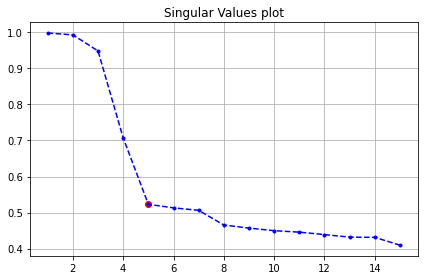

No. of lags: 15
No. of states: 5
Indices of u: [0 1 2]
Indices of y: [3 4 5]
State-space matrices:
[[ 0.97221771  0.03127698 -0.06646283  0.02048975  0.00144735]
 [-0.08495919  0.97937795 -0.03163041 -0.01049027  0.00733778]
 [ 0.3911072   0.14720301  0.7707343   0.00349208  0.03272263]
 [-0.13830291  0.01778285  0.07288539  0.86371856  0.07250984]
 [-0.21679005 -0.07630827  0.04779034 -0.04187674  0.87700248]]
[[ 0.00015736  0.00081424  0.00034443]
 [ 0.00031645  0.00141946  0.00056474]
 [ 0.00058238 -0.01014129 -0.00535697]
 [-0.00271321  0.00383953  0.00178875]
 [ 0.00029113  0.00698993  0.00399985]]
[[-30.69821357 -19.93247895  23.87432887   1.65507361  -0.16085297]
 [ 30.49964197 -11.92780583  -3.45548034  -0.03188108   0.35942743]
 [ 27.9651233    9.63886828   5.9612472   -0.04616285  -0.12348461]]
[[ 0.03724187  0.4007925   0.18701006]
 [ 0.06197259 -0.05029353 -0.02932333]
 [ 0.00590386  0.0465788   0.02426705]]
[[-1.20125207e-06  1.47298306e-03  7.77245337e-03]
 [-6.50815179e-

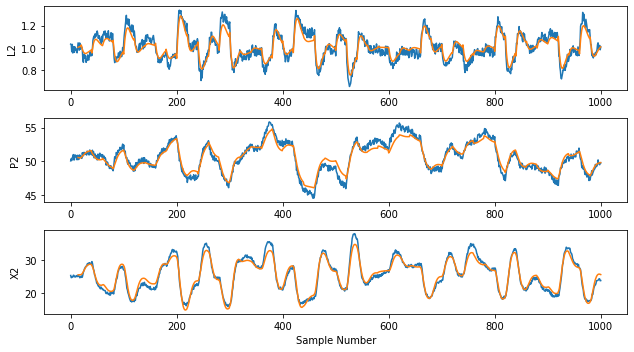

Training Performance
L2 fitness: 85.198%
P2 fitness: 91.476%
X2 fitness: 95.450%
Average:    90.708%
Ident time: 0.17 sec
Sim time:   0.02 sec


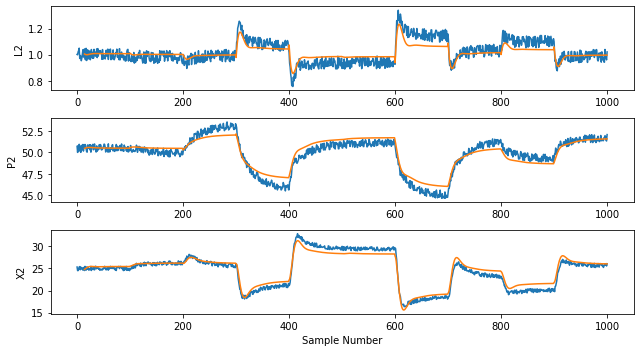

Validation Performance
L2 fitness: 63.677%
P2 fitness: 88.007%
X2 fitness: 93.994%
Average:    81.893%
Ident time: 0.17 sec
Sim time:   0.01 sec


In [13]:
YI, UI = np.array([3, 4, 5]), np.array([0, 1, 2])

sys = CVA(verbose=1)
sys.identify(Z_train, UI, YI)
sys.display()

# Training Performance
x_pred, y_pred, exit_code = sys.simulate(Z_train)
r2 = sys.R2_score(Z_train, y_pred)

plt.figure(figsize=(9, 5))
var_name = ('L2', 'P2', 'X2')
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_train[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_train.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

print('Training Performance')
print(f"L2 fitness: {r2[0]*100:.3f}%")
print(f"P2 fitness: {r2[1]*100:.3f}%")
print(f"X2 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")
print(f"Ident time: {sys.ident_time:.2f} sec")
print(f"Sim time:   {sys.sim_time:.2f} sec")

# Validation Performance
x_pred, y_pred, exit_code = sys.simulate(Z_valid)
r2 = sys.R2_score(Z_valid, y_pred)

plt.figure(figsize=(9, 5))
var_name = ('L2', 'P2', 'X2')
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_valid[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_valid.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

print('Validation Performance')
print(f"L2 fitness: {r2[0]*100:.3f}%")
print(f"P2 fitness: {r2[1]*100:.3f}%")
print(f"X2 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")
print(f"Ident time: {sys.ident_time:.2f} sec")
print(f"Sim time:   {sys.sim_time:.2f} sec")

In [14]:
with open("evap_cva_sys.pkl", "wb") as file:
    pickle.dump(sys, file)